# Verify the numerical advection-diffusion solver we are using in the Bayesian inverse problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Based on the notebook analytical "analytical solution with constant D and varying source.ipynb"
def C_analytical(X, T, Pec, C0=1):
    prefactor = C0 / np.sqrt(4 * np.pi * T / Pec)
    exparg = -Pec * (X - T)**2 / (4 * T)
    return prefactor * np.exp(exparg)

In [3]:
# imports
import numpy as np
import cuqi
import sys
import matplotlib.pyplot as plt
from cuqi.distribution import Gaussian, JointDistribution
from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
import sys
import os
sys.path.append("../ear_aqueducts")
from advection_diffusion_inference_utils import create_domain_geometry, create_PDE_form, build_grids

dill version:  0.3.6


In [4]:
factor = 0.61 # factor for refining the grid and the time steps
C0 = 1000
L = 500
n_grid = int(100*factor) # Number of solution nodes
h = L/(n_grid+1) # Space step size
grid = np.linspace(h, L-h, n_grid)

T_0 = 10
tau_max = 30*60 # Final time in sec
cfl = 4/2 # The cfl condition to have a stable solution
        # the method is implicit, we can choose relatively large time steps 
dt_approx = cfl*h**2 # Defining approximate time step size
n_tau = int((tau_max-T_0)/dt_approx)+1 # Number of time steps

tau = np.linspace(T_0, tau_max, n_tau)
# insert 4 time steps between the first two time steps
additional_timesteps = np.array([T_0+(tau[1]-tau[0])*frac for frac in [0.2, 0.4, 0.6, 0.8]])
num_added_timesteps = len(additional_timesteps)
tau = np.concatenate((tau[:1], additional_timesteps, tau[1:]))
n_tau = len(tau)
print(tau)


velocity_fd = 2 # works for negative velocity as well.
D_fd = 1000 #1000 #400 #100
pec_fd = velocity_fd*L/D_fd

[  10.           37.53846154   65.07692308   92.61538462  120.15384615
  147.69230769  285.38461538  423.07692308  560.76923077  698.46153846
  836.15384615  973.84615385 1111.53846154 1249.23076923 1386.92307692
 1524.61538462 1662.30769231 1800.        ]


In [5]:
# now use the analytical solution to generate the data
u = np.zeros((n_tau, n_grid))

for i, t in enumerate(tau):
    u[i, :] = C_analytical(grid / L, (velocity_fd / L) * (t), pec_fd, C0=C0)

In [6]:
#%% STEP 4: Create the PDE grid and coefficients grid
#----------------------------------------------------
# PDE and coefficients grids
print(L)
coarsening_factor = 5/factor
n_grid_c = 20
_, grid_c, grid_c_fine, _, _ = build_grids(L, coarsening_factor, n_grid_c)

#%% STEP 5: Create the PDE time steps array
#------------------------------------------
#tau = create_time_steps(h, cfl, tau_max)

#%% STEP 6: Create the domain geometry
#-------------------------------------
G_c = create_domain_geometry(grid_c, "advection_diffusion")

# STEP 7: Create the PDE form
#----------------------------
# c_bc is the analytical solution of the PDE at the boundary x = 0, evaluated
# at tau grid points
c_bc = C_analytical(0, velocity_fd/L*tau, pec_fd, C0=C0)
r_bc = C_analytical(L / L, (velocity_fd / L) * (tau), pec_fd, C0=C0)
u0 = C_analytical(grid / L, (velocity_fd / L) * T_0, pec_fd, C0=C0)
PDE_form = create_PDE_form(c_bc, r_bc, grid, grid_c, grid_c_fine, n_grid, h, tau,
                           "advection_diffusion", u0)

# STEP 8: Create the CUQIpy PDE object
#-------------------------------------
PDE = TimeDependentLinearPDE(PDE_form,
                             tau,
                             grid_sol=grid,
                             method='backward_euler',
                             time_obs='all') 

# STEP 9: Create the range geometry
#----------------------------------
G_cont2D = Continuous2D((grid, tau))

# STEP 10: Create the CUQIpy PDE model
#-------------------------------------
A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_c)

500


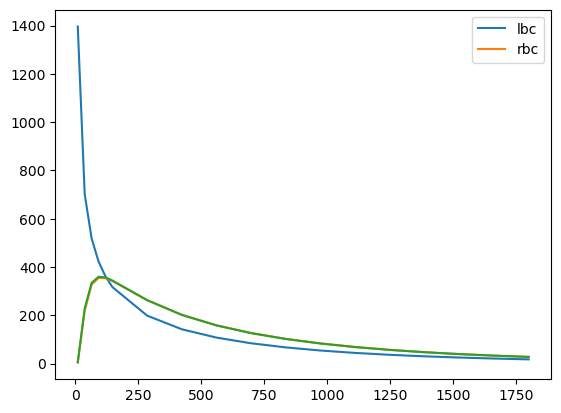

In [7]:
# plot lbc and rbc
plt.plot(tau, c_bc, label='lbc')
plt.plot(tau, r_bc, label='rbc')
plt.plot(tau,u[:,-1])
plt.legend()

In [8]:
print(tau.shape)
print(c_bc.shape)
print(grid_c.shape)
print(G_cont2D.par_dim)
print(grid.shape)

(18,)
(18,)
(21,)
1098
(61,)


In [9]:
# diffusion paramter is the Peclet number in this case
# Pec = a/(D*L)

# advection parameter is the velocity in this case

exact_x = np.zeros(len(grid_c) +1)
exact_x[:-1] = np.sqrt(D_fd)
exact_x[-1] = velocity_fd
sol = A(exact_x)
sol = sol.reshape(( len(grid), len(tau)))


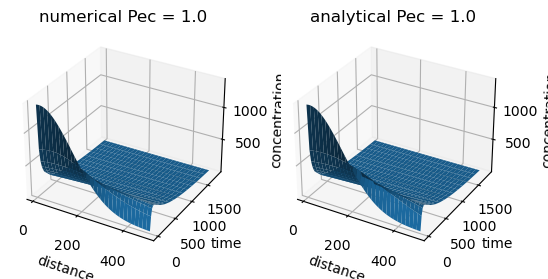

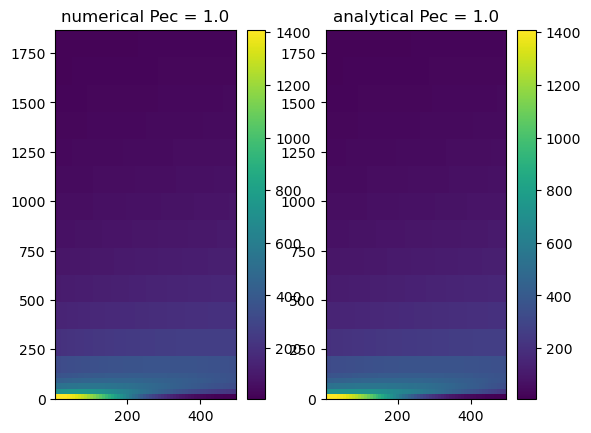

In [10]:
fig, axes = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
idx = 0
plt.sca(axes[0])
xgrid, tgrid = np.meshgrid(grid, tau)

axes[0].plot_surface(
    xgrid[idx:, :],
    tgrid[idx:, :],
    sol.T[idx:, :]
)

plt.xlabel("distance")
plt.ylabel("time")
axes[0].set_zlabel("concentration")
plt.title(f"numerical Pec = {pec_fd}")


plt.sca(axes[1])


axes[1].plot_surface(
    xgrid[idx:, :],
    tgrid[idx:, :],
    u[idx:, :]
)

plt.xlabel("distance")
plt.ylabel("time")
axes[1].set_zlabel("concentration")
plt.title(f"analytical Pec = {pec_fd}")
plt.show()


# plot as 2D heat map
fig, axes = plt.subplots(1, 2)
idx = 0
plt.sca(axes[0])
plt.pcolor(xgrid[idx:, :], tgrid[idx:, :], sol.T[idx:, :])
plt.title(f"numerical Pec = {pec_fd}")

plt.colorbar()

plt.sca(axes[1])
plt.pcolor(xgrid[idx:, :], tgrid[idx:, :], u[idx:, :])
plt.title(f"analytical Pec = {pec_fd}")
plt.colorbar()




In [11]:
# error between the two
idx = num_added_timesteps+1
print(u[idx:,:].shape)
print(sol.T[idx:, :].shape)

error = np.linalg.norm(u[idx:,:]-sol.T[idx:, :])
relative_error = error/np.linalg.norm(u[idx:,:])

print(f"Error: {error}")
print(f"Relative Error: {relative_error}")

(13, 61)
(13, 61)
Error: 50.738453756293055
Relative Error: 0.012658655425049585


### Compare error in observation points

In [12]:
# read time and location from the data
from advection_diffusion_inference_utils import (read_data_files,
                                                 create_experiment_tag,
                                                 Args,
                                                 plot_time_series)
args = Args()
noise_level_list= ["fromDataVar" , "fromDataAvg", "avgOverTime", 0.1, 0.2]
args.noise_level = noise_level_list[3]
args.animal = 'm1'
args.ear = 'l'
args.num_ST =0
args.inference_type = 'heterogeneous'
args.unknown_par_type = 'sampleMean'
args.unknown_par_value = ['m1:l:NUTS:constant:100.0:real:heterogeneous:1000:0.1:v:April22:2024:a::4:5@../../../Collab-BrainEfflux-Data/April_2x_2024_b']

tag = create_experiment_tag(args)
print(tag)
times, locations, real_data, real_std_data = read_data_files(args)



m1_l_MH_sampleMean_m1:l:NUTS:constant:100.0:real:heterogeneous:1000:0.1:v:April22:2024:a::4:5_syntheticFromDiffusion_heterogeneous_20_0.1_v_temp__0_5_none_zero
CA data.


Error: 12.655482717004679
Relative Error: 0.005531070551749851


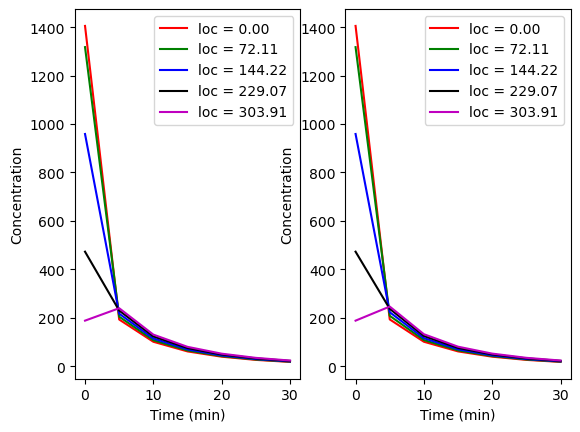

In [13]:
import scipy.interpolate
fig, axes = plt.subplots(1, 2)

# analytical sol at times and locations (using 2D interpolation on u)
plt.sca(axes[0])
analytical_solution_obs = scipy.interpolate.RectBivariateSpline(grid, tau, u.T)(locations, times)
plot_time_series(times, locations, analytical_solution_obs)


# numerical sol at times and locations (using 2D interpolation on sol)
plt.sca(axes[1])
numerical_solution_obs = scipy.interpolate.RectBivariateSpline(grid, tau, sol)(locations, times)
plot_time_series(times, locations, numerical_solution_obs)

# print relative error between the two
print(f"Error: {np.linalg.norm(analytical_solution_obs-numerical_solution_obs)}")
print(f"Relative Error: {np.linalg.norm(analytical_solution_obs-numerical_solution_obs)/np.linalg.norm(analytical_solution_obs)}")

### Verify rbc implementation
The idea is to generate another numerical solution `sol_flipped` where the bc are flipped (the left boundary condition is applied to the right boundary and vice versa), the initial condition is flipped, and the advection velocity is flipped. The solution, `sol_flipped` should be the same as the original solution, flipped.

In [14]:
# Solve the same problem but with flipped boundary conditions (numerically)


# STEP 7b: Create the PDE form
#----------------------------
# c_bc is the analytical solution of the PDE at the boundary x = 0, evaluated
# at tau grid points
PDE_form_flipped = create_PDE_form(real_bc_l=r_bc, real_bc_r=c_bc,
                           grid=grid, grid_c=grid_c, grid_c_fine=grid_c_fine,
                           n_grid=n_grid, h=h, times=tau,
                           inference_type="advection_diffusion", u0=np.flip(u0))

# STEP 8b: Create the CUQIpy PDE object
#-------------------------------------
PDE_flipped = TimeDependentLinearPDE(PDE_form_flipped,
                             tau,
                             grid_sol=grid,
                             method='backward_euler',
                             time_obs='all') 


# STEP 10b: Create the CUQIpy PDE model
#-------------------------------------
A_flipped = PDEModel(PDE_flipped, range_geometry=G_cont2D, domain_geometry=G_c)


In [15]:
exact_x_2 = np.copy(exact_x)
exact_x_2[-1] = -exact_x[-1]
sol_flipped = A_flipped(exact_x_2)
sol_flipped = sol_flipped.reshape(( len(grid), len(tau)))
# flip the solution
sol_flipped = np.flip(sol_flipped, axis=0)

In [16]:
# compute the error between the two numerical solutions sol and sol_flipped
idx = 0
error_flipped = np.linalg.norm(sol.T[idx:, :]-sol_flipped.T[idx:, :])
relative_error_flipped = error_flipped/np.linalg.norm(sol.T[idx:, :])

print(f"Error: {error_flipped}")
print(f"Relative Error: {relative_error_flipped}")

Error: 2.6021126930419766e-11
Relative Error: 2.5572702463762718e-15


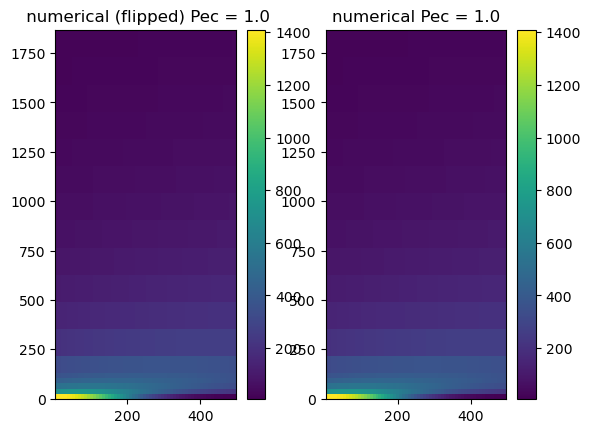

In [17]:
# plot as 2D heat map
fig, axes = plt.subplots(1, 2)
idx = 0
plt.sca(axes[0])
plt.pcolor(xgrid[idx:, :], tgrid[idx:, :], sol_flipped.T[idx:, :])
plt.title(f" numerical (flipped) Pec = {pec_fd}")

plt.colorbar()

plt.sca(axes[1])
plt.pcolor(xgrid[idx:, :], tgrid[idx:, :], sol.T[idx:, :])
plt.title(f"numerical Pec = {pec_fd}")
plt.colorbar()

